# Several ways to get the normal vectors on nodes of a mesh

I would like to use the normal vector on nodes(dofs) of the mesh. But we only know the normal vector for the cell of mesh.
The normal vector on the nodes is undefined (multi-value). Here are some ways to obtian it.

1. By the expression of the surface if we know it
    
   Just project the mesh points to the surface, and compute the normal vector.
   
2. Compute the curvature of the mesh, and then normalize it.

3. Interpolat or project the cell nomal to nodes.

    In Firedrake, we can use `CellNormal` which is a ufl object.
    
4. Weight average of the cell normal   # TODO

5. Recovery from the mesh  # TODO
   
   Fit a local polynomial surface to the patch including the nodes, and use the normal of the polynomial surface.

**Q1: Should be 3 and 4 classed into one category?**  
**Q2: Which one will give the more accuray results?**

In [49]:
from firedrake import *
import matplotlib.pyplot as plt

order = 2
refinement_level = 2
domain = IcosahedralSphereMesh(radius=6371, refinement_level=refinement_level, degree=order)
domain.init_cell_orientations(SpatialCoordinate(domain))

def get_error_max(fun1, fun2):
    data1 = fun1.dat.data
    data2 = fun2.dat.data
    err = data1 - data2
    v = [sqrt(__) for __ in sum([err[:, _]**2 for _ in range(0, 3)]) ]
    return max(v), err

def get_vector_norm(fun):
    data = fun.dat.data
    v = [sqrt(__) for __ in sum([data[:, _]**2 for _ in range(0, 3)]) ]
    return v

def get_vector_norm_minus_one(fun):
    data = fun.dat.data
    v = [sqrt(__) - 1 for __ in sum([data[:, _]**2 for _ in range(0, 3)]) ]
    return v

# normalize vector function
def normalize_vfun(k_h, name=None):
    k_hat = k_h/sqrt(k_h[0]**2 + k_h[1]**2+k_h[2]**2)
    k_new = Function(k_h.function_space(), name=name)
    k_new.interpolate(k_hat)
    return k_new

def plot_3d_2d(fun, vec):
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 2, 1, projection='3d')
    trisurf(fun, axes=ax1)
    ax2 = plt.subplot(1, 2, 2)
    plt.plot(vec, axes=ax2)

## By the expression of the surface

In [2]:
x, y, z = SpatialCoordinate(domain)
r = sqrt(x**2 + y**2+z**2)
k_expr = as_vector((x/r, y/r, z/r))   # we can use this in the variational form.

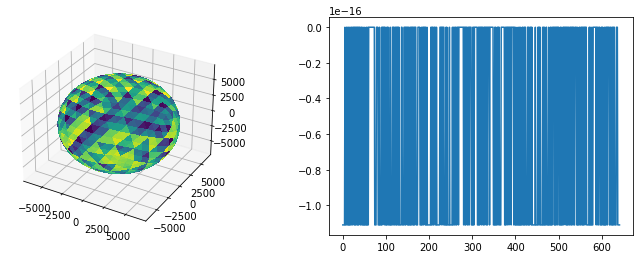

In [3]:
# to plot `k`, we should interpolate it to some space
V_k = VectorFunctionSpace(domain, "CG", order)
k_inter_from_expr = Function(V_k, name='k_inter_from_expr')
k_inter_from_expr.interpolate(k_expr)
# k_h_norm = get_vector_norm(k_h)
k_inter_from_expr_norm_minus_one = get_vector_norm_minus_one(k_inter_from_expr)

plot_3d_2d(k_inter_from_expr, k_inter_from_expr_norm_minus_one)

## Compute the curvature of the mesh

In [4]:
x, y, z = SpatialCoordinate(domain)
X = as_vector((x, y, z))

V_kappa = VectorFunctionSpace(domain, 'DG' if order == 0 else 'CG', order)

kappa_trial = TrialFunction(V_kappa)
kappa_test = TestFunction(V_kappa)

a_kappa = dot(kappa_trial, kappa_test)*dx
f_kappa = inner(grad(X), grad(kappa_test))*dx

kappa = Function(V_kappa, name='kappa')
solve(a_kappa == f_kappa, kappa)

kappa_normalize = normalize_vfun(kappa, name='kappa_normalize')


In [70]:
err_max, err  = get_error_max(k_inter_from_expr, kappa_normalize)
err_fun = Function(V_kappa, name='err')
with err_fun.dat.vec as vec:
    vec.setArray(err)

In [72]:
outfile = File("data/kappa-order" + str(order) + ".pvd")
outfile.write(kappa, kappa_normalize, k_inter_from_expr, err_fun)

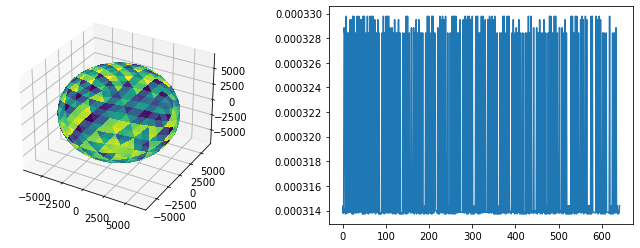

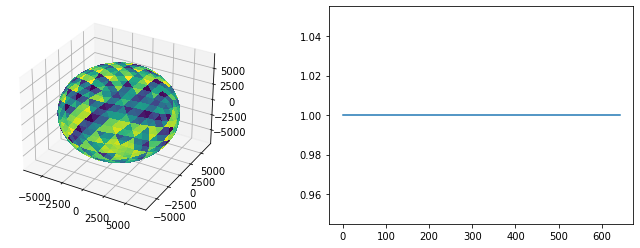

In [73]:
# plot
kappa_norm = get_vector_norm(kappa)
kappa_normalize_norm = get_vector_norm(kappa_normalize)

plot_3d_2d(kappa, kappa_norm)
plot_3d_2d(kappa_normalize, kappa_normalize_norm)

## Interpolate or project the cell normal to nodes

In [266]:
def get_cell_normal(mesh, method='interpolate', order=1):
    k = CellNormal(mesh)
    V_k = VectorFunctionSpace(mesh, 'DG' if order == 0 else 'CG', order)
    if method == 'interpolate':
        k_h = Function(V_k, name='k_inte_'+str(order))
        k_h.interpolate(k)
    elif method == 'project':
        k_trial = TrialFunction(V_k)
        k_test = TestFunction(V_k)
        k_h = Function(V_k, name='k_proj_'+str(order))
        a = dot(k_test, k_trial)*dx
        f = dot(k, k_test)*dx
        solve(a == f, k_h)
    else:
        raise Exception("get_cell_normal: unknow method %s" % method)
    
    return k_h

def get_k_by_interpolation_and_projection(mesh, order):
    '''Compute cell normal by interpolation and projection from CellNormal'''
    k = CellNormal(mesh)
    V_k = VectorFunctionSpace(mesh, 'DG' if order == 0 else 'CG', order)
        
    k_trial = TrialFunction(V_k)
    k_test = TestFunction(V_k)
    
    k_proj = Function(V_k, name='k_proj_'+str(order))
    k_inte = Function(V_k, name='k_inte_'+str(order))

    a = dot(k_test, k_trial)*dx
    f = dot(k, k_test)*dx
    solve(a == f, k_proj)
    k_inte.interpolate(k)
    return k_inte, k_proj

def show_normal_vector_minus_one(domain, method='interpolate', order=1):
    
    k_h = get_cell_normal(domain, method=method, order=order)
    k_hat = k_h/sqrt(k_h[0]**2 + k_h[1]**2+k_h[2]**2)
    k_new = Function(k_h.function_space())
    k_new.interpolate(k_hat)
    
    k_h_norm_minus_one = get_vector_norm_minus_one(k_h)
    k_new_norm_minus_one = get_vector_norm_minus_one(k_new)
    
    plt.figure(figsize=(10, 4)) 
    plt.subplot(1, 2, 1)
    plt.plot(k_h_norm_minus_one)
    plt.title(method + ' ' + str(order))
    plt.subplot(1, 2, 2)
    plt.plot(k_new_norm_minus_one)
    plt.title('normlization ' + method + ' ' + str(order))

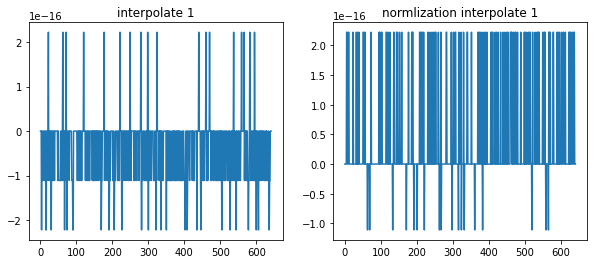

In [267]:
show_normal_vector_minus_one(domain, method='interpolate', order=1)

In [268]:
outfile = File("data/normal-vector.pvd")
ks = []
for i in range(0, 4):
    k_inte, k_proj = get_k_by_interpolation_and_projection(domain, i)
    ks.extend([k_inte, k_proj])
    # print('done: order' + str(i))

outfile.write(*ks)